# Notebook 009: Initial EDA for Crime Incident Reports

This notebooks contains preliminary EDA for Boston crime incident report records.

Note that this is not a complete EDA, but has just been created to begin to understand the structure of this dataset and how other datasets might be used to enrich it with additional features

In [184]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [185]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/crime'

READDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
WRITEDIR_ROOT = os.path.join(DATA_ROOT, 'interim/crime')

readfile_crime = os.path.join(READDIR_ROOT, 'crime/crime-incidents.csv')

readfile_sam = os.path.join(READDIR_ROOT, 'boston/sam-addresses.csv')
readfile_zipshapes = os.path.join(READDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(READDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(READDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(READDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(READDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(READDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}'.format(
        readfile_crime, readfile_sam, readfile_zipshapes, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/raw/crime/crime-incidents.csv
	../data/raw/boston/sam-addresses.csv
	../data/raw/shapefile/zipcodes/ZIP_Codes.shp


In [186]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

In [187]:
# read in SAM address data and related shapefiles
df_crime = pd.read_csv(readfile_crime, dtype=str)
df_sam = pd.read_csv(readfile_sam, dtype=str)
gdf_zips = gpd.read_file(readfile_zipshapes)
gdf_boston = gpd.read_file(readfile_cityshape)
gdf_streets = gpd.read_file(readfile_streetshapes)
gdf_tracts = gpd.read_file(readfile_tractshapes)
gdf_hoods = gpd.read_file(readfile_hoodshapes)
gdf_zonesubs = gpd.read_file(readfile_zonesubshapes)

# convert SAM data lat/lon values to floats
df_sam[['X', 'Y']] = df_sam[['X', 'Y']].astype(float)
# convert crime data lat/lon values to floats
df_crime[['Lat', 'Long']] = df_crime[['Lat', 'Long']].astype(float)

In [188]:
# check info of crime dataframe
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436666 entries, 0 to 436665
Data columns (total 17 columns):
INCIDENT_NUMBER        436666 non-null object
OFFENSE_CODE           436666 non-null object
OFFENSE_CODE_GROUP     426840 non-null object
OFFENSE_DESCRIPTION    436666 non-null object
DISTRICT               434440 non-null object
REPORTING_AREA         436666 non-null object
SHOOTING               11573 non-null object
OCCURRED_ON_DATE       436666 non-null object
YEAR                   436666 non-null object
MONTH                  436666 non-null object
DAY_OF_WEEK            436666 non-null object
HOUR                   436666 non-null object
UCR_PART               426730 non-null object
STREET                 423236 non-null object
Lat                    399636 non-null float64
Long                   399636 non-null float64
Location               436666 non-null object
dtypes: float64(2), object(15)
memory usage: 56.6+ MB


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,RIVERVIEW DR,NaN,NaN,"(0.00000000, 0.00000000)"
1,I92089785,3005,NaN,SICK ASSIST,E13,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,NaN,WASHINGTON ST,NaN,NaN,"(0.00000000, 0.00000000)"
2,I90583827,1402,NaN,VANDALISM,E18,498,0,2019-11-02 05:09:00,2019,11,Saturday,5,NaN,BRADLEE ST,NaN,NaN,"(0.00000000, 0.00000000)"
3,I192082859,00724,Auto Theft,AUTO THEFT,E18,519,NaN,2019-10-13 09:28:24,2019,10,Sunday,9,Part One,LINCOLN ST,42.259518,-71.121563,"(42.25951765, -71.12156299)"
4,I192082751,00724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)"


In [189]:
# change datatypes for crime data columns as needed
df_crime['MONTH'] = df_crime['MONTH'].astype(int)
df_crime['HOUR'] = df_crime['HOUR'].astype(int)

In [190]:
# count records per calendar year
crime_count_year = df_crime['YEAR'].value_counts(dropna=False).sort_index()

# identify minimum and maximum month with records for each given year
min_max_months_year = {
    year: (min(month_set), max(month_set))
    for year, month_set in zip(
        crime_count_year.index,
        [
            set(df_crime.loc[df_crime['YEAR']==year]['MONTH'].values)
            for year in crime_count_year.index
        ]
    )
}

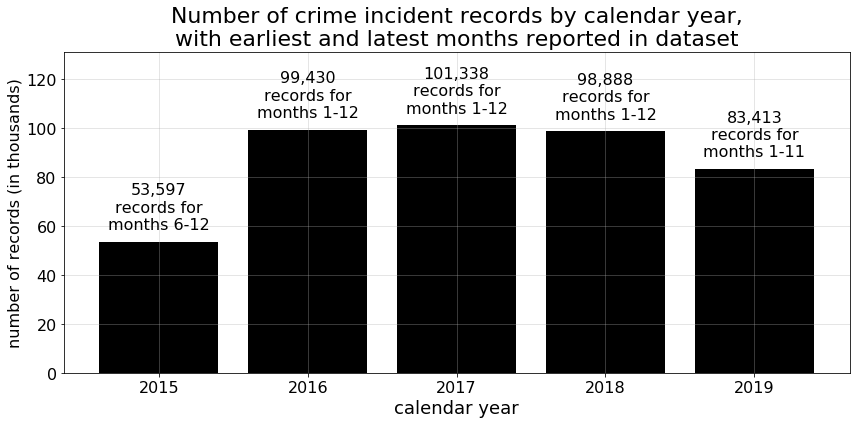

In [191]:
# print summary of years for all data records to identify partial years

savefig = True
scale = 1000
text_offset = 5
yscale_offset = 30

fig, ax = plt.subplots(figsize=(12, 6))

plt.title(
    "Number of crime incident records by calendar year,\n"\
    "with earliest and latest months reported in dataset",
    fontsize=22,
)

plt.bar(crime_count_year.index, crime_count_year.values/scale, color='k')

for (i, (year, values)), count in zip(enumerate(min_max_months_year.items()), crime_count_year.values/scale):
    ax.text(
        i, count+text_offset,
        '{0:,}\nrecords for\nmonths {1}-{2}'.format(int(count*scale), values[0], values[1]),
        color='k',
        fontsize=16,
        horizontalalignment='center'
    ) 

ax.tick_params(labelsize=16)
ax.set_ylabel("number of records (in thousands)", fontsize=16)
ax.set_ylim(bottom=0, top=max(crime_count_year.values/scale)+yscale_offset)
ax.set_xlabel("calendar year", fontsize=18)
ax.grid(':', alpha=0.4)    
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-reports-by-year.png'))
plt.show();

In [192]:
############################################################
## SUBSET DATAFRAME TO INCLUDE ONLY YEARS WITH COMPLETE DATA
############################################################
subset_years = ['2016', '2017', '2018']

df_crime = df_crime.loc[df_crime['YEAR'].isin(subset_years)]

print(
    'The crime incidents dataset was subset to include only years with'\
    'records for all calendar months (i.e. complete years of data).\n\n'\
    'The following calendar years were retained:\t{0}\n\n'\
    'The resulting dataframe contains {1:,} records, broken down by year as:\n\n'\
    '{2}'.format(subset_years, len(df_crime), df_crime['YEAR'].value_counts().sort_index())
)

The crime incidents dataset was subset to include only years withrecords for all calendar months (i.e. complete years of data).

The following calendar years were retained:	['2016', '2017', '2018']

The resulting dataframe contains 299,656 records, broken down by year as:

2016     99430
2017    101338
2018     98888
Name: YEAR, dtype: int64


In [193]:
## Identify invalid or missing location data for both lat and long columns
print(
    'A summary count of invalid coordinate data by value is shown below. '\
    'These are missing data points that must be resolved:\n\n'\
    'Invalid Latitude value counts:\n{0}\n\nInvalid Longitude value counts:\n{0}\n'\
    ''.format(
        df_crime.loc[
            (df_crime['Lat'].astype(float)<42) | (df_crime['Lat'].isnull())
        ]['Lat'].value_counts(dropna=False),
        df_crime.loc[
            (df_crime['Long'].astype(float)>-70) | (df_crime['Long'].isnull())
        ]['Long'].value_counts(dropna=False)
    )
    
)

A summary count of invalid coordinate data by value is shown below. These are missing data points that must be resolved:

Invalid Latitude value counts:
NaN     20402
-1.0      795
Name: Lat, dtype: int64

Invalid Longitude value counts:
NaN     20402
-1.0      795
Name: Lat, dtype: int64



In [194]:
# Map -1 lat and long values to np.nan for further cleansing
for variable in ['Lat', 'Long']:
    df_crime[variable] = df_crime[variable].replace({-1: np.nan})

print(
    'Now the NaN values for both Lat and Long are:\n\n'
    '\tMissing Latitudes:\t{0:,}\n\tMissing Longitudes:\t{1:,}\n'.format(
        sum(df_crime['Lat'].isnull()),
        sum(df_crime['Long'].isnull())
    )
)

Now the NaN values for both Lat and Long are:

	Missing Latitudes:	21,197
	Missing Longitudes:	21,197



In [219]:
# create subsetted dataframe with only records that have coords
df_crime_locs = df_crime.loc[~df_crime['Lat'].isnull()]

# add binary label for records that have coords
df_crime['is_coord'] = df_crime['Lat'].isnull().values.astype(int)

In [ ]:
################################################
# MATCH SHAPES FOR ALL RECORDS WITH COORDINATES
################################################



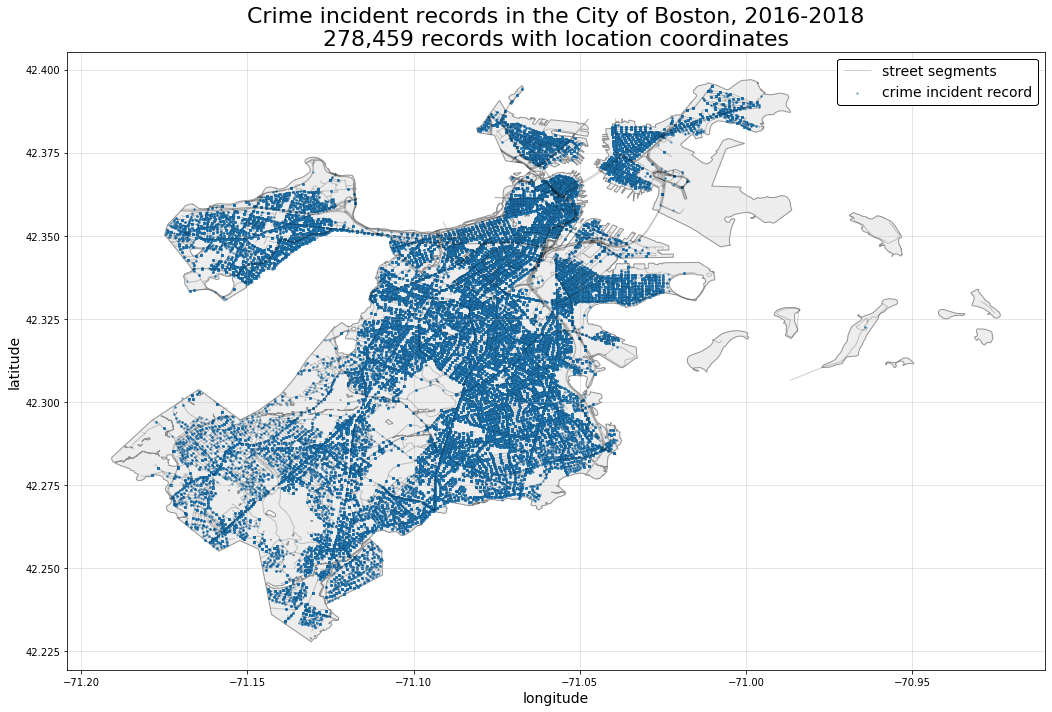

CPU times: user 4.75 s, sys: 7.69 ms, total: 4.76 s
Wall time: 4.47 s


In [196]:
%%time
savefig=True

# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='k', linewidth=1, alpha=0.2, label='street segments')
plt.title(
    'Crime incident records in the City of Boston, {0}-{1}\n'\
    '{2:,} records with location coordinates'.format(
        min(subset_years),
        max(subset_years),
        len(df_crime_locs),
    ),
    fontsize=22
)
plt.scatter(
    df_crime_locs['Long'], df_crime_locs['Lat'],
    color='tab:blue', alpha=0.5, s=2,
    label='crime incident record'
)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-incidents-with-coords.png'))
plt.show();

In [208]:
# calculate percentage of records with missing coords by year
missing_coords_year = df_crime.loc[
    (df_crime['Lat'].isnull()) | (df_crime['Long'].isnull())
]['YEAR'].value_counts().sort_index() / df_crime['YEAR'].value_counts().sort_index()

# calculate percentage of records with missing coords by month for each year
missing_coords_month_year = [
    df_crime.loc[
        (df_crime['YEAR']==year) & 
        ((df_crime['Lat'].isnull()) | (df_crime['Long'].isnull()))
    ]['MONTH'].value_counts().sort_index() / df_crime.loc[df_crime['YEAR']==year]['MONTH'].value_counts().sort_index()
    for year in subset_years
]

# calculate percentage of records with missing coords by day of week
missing_coords_day = df_crime.loc[
    (df_crime['Lat'].isnull()) | (df_crime['Long'].isnull())
]['DAY_OF_WEEK'].value_counts().sort_index() / df_crime['DAY_OF_WEEK'].value_counts().sort_index()
# sort days, sunday - saturday
missing_coords_day = missing_coords_day.loc[
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
]

# calculate percentage of records with missing coords by hour of day
missing_coords_hour = df_crime.loc[
    (df_crime['Lat'].isnull()) | (df_crime['Long'].isnull())
]['HOUR'].value_counts().sort_index() / df_crime['HOUR'].value_counts().sort_index()

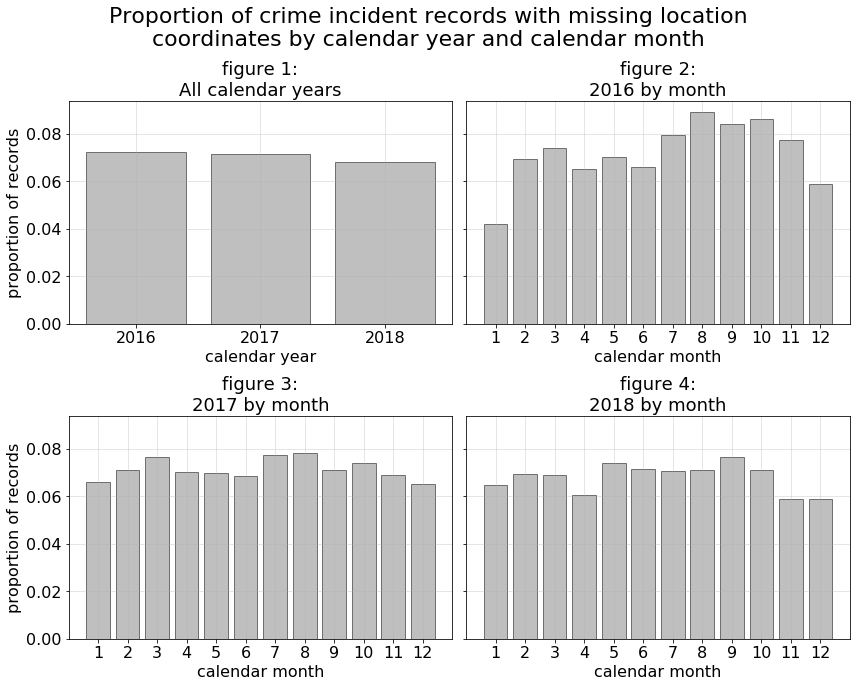

In [211]:
# print summary of years for all data records to identify partial years

savefig = True

fig, axes = plt.subplots(2,2, sharey=True, figsize=(12, 10))

plt.suptitle(
    "Proportion of crime incident records with missing location\n"\
    "coordinates by calendar year and calendar month",
    fontsize=22,
)

for (i, ax), data in zip(
    enumerate(axes.flat),
    [missing_coords_year, *missing_coords_month_year]
):
    ax.bar(data.index, data.values, color='gray', edgecolor='k', alpha=0.5)
    ax.tick_params(labelsize=16)
    ax.set_xticks(data.index)
    ax.grid(':', alpha=0.4)    
    if i == 0:
        ax.set_xlabel("calendar year", fontsize=16)
        ax.set_title('figure 1:\nAll calendar years', fontsize=18)
    else:
        ax.set_xlabel("calendar month", fontsize=16)
        ax.set_title(
            'figure {0}:\n{1} by month'.format(i+1, subset_years[i-1]),
            fontsize=18,
        )
    if i%2 == 0:
        ax.set_ylabel("proportion of records", fontsize=16)
        

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-reports-missing-coords-year-month.png'))
plt.show();

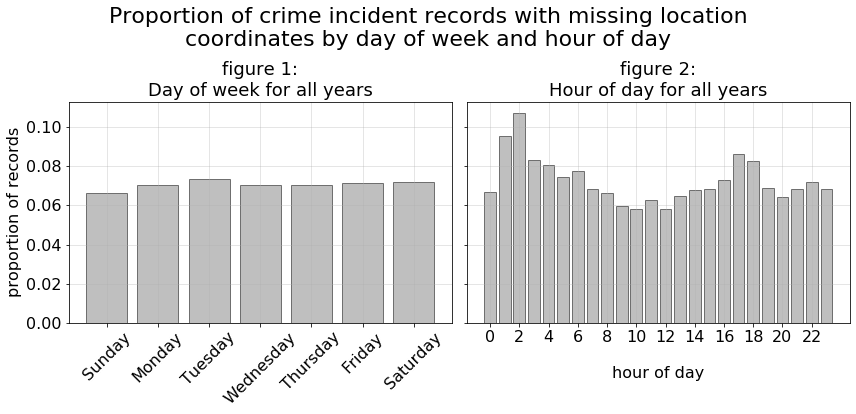

In [213]:
# print summary of years for all data records to identify partial years

savefig = True

fig, axes = plt.subplots(1,2, sharey=True, figsize=(12, 6))

plt.suptitle(
    "Proportion of crime incident records with missing location\n"\
    "coordinates by day of week and hour of day",
    fontsize=22,
)

for (i, ax), data in zip(
    enumerate(axes.flat),
    [missing_coords_day, missing_coords_hour]
):
    ax.bar(data.index, data.values, color='gray', edgecolor='k', alpha=0.5)
    ax.tick_params(labelsize=16)
    ax.set_xticks(data.index)
    ax.grid(':', alpha=0.4)    
    if i == 0:
        ax.set_xticklabels(data.index, rotation=45)
        ax.set_title('figure 1:\nDay of week for all years', fontsize=18)
        ax
    else:
        ax.set_xlabel("\nhour of day", fontsize=16)
        ax.set_xticks(data.index[::2])
        ax.set_xticklabels(data.index[::2])
        ax.set_title(
            'figure {0}:\nHour of day for all years'.format(i+1),
            fontsize=18,
        )
    if i%2 == 0:
        ax.set_ylabel("proportion of records", fontsize=16)
        

plt.tight_layout(rect=[0, 0.03, 1, 0.88])
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-reports-missing-coords-day-hour.png'))
plt.show();

In [173]:
def calc_t_stats(X_data, y_data, sort=False) -> pd.Series:
    """
    Calculates t_stats for all predictors in an X_data using 
    binary (1, 0) classifiers in a corresponding y_data
    
    X_data: pd.DataFrame containing predictors of interest and
            observed values for those predictors
    y_data: pd.Series containing binary (0,1) classifiers for
            variable of interest corresponding to all observed
            values X in X_data
    sort: boolean, default=False, determines whether the resulting
          t_stats series is sorted from largest to smallest values
    returns: pd.Series wherein the index are the predictor names
             and the values are the corresponding t_stats
    """
    # identify rows in dataset representing each response class 1 and 0 
    bool_1, bool_0 = (y_data.loc[:] == 1).values, (y_data.loc[:] == 0).values

    # subset X_data based on corresponding response classes
    X_1, X_0 = X_data.loc[bool_1], X_data.loc[bool_0]
    
    # calculate means for each subset of X values
    X_1_mean, X_0_mean = X_1.mean(axis=0), X_0.mean(axis=0)

    # calculate variances for each subset of X values
    X_1_var = X_1.var(axis=0)
    X_0_var = X_0.var(axis=0)

    # count number of observations in each subset of X values
    X_1_n = len(X_1)
    X_0_n = len(X_0)

    # calculate nominator and denominator for t_stat
    nom = (X_1_mean - X_0_mean).abs()
    denom = ((X_1_var/X_1_n) + (X_0_var/X_0_n))**.5
    
    # calculate and return t_stat, sorting values if specified
    if sort:
        return (nom / denom).sort_values(ascending=False)
    
    else:
        return (nom / denom)

In [221]:
df_crime.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,is_coord
955,I192077559,03115,Investigate Person,INVESTIGATE PERSON,B3,468,NaN,2018-04-30 09:00:00,2018,4,Monday,9,Part Three,HAZLETON ST,42.279971,-71.095534,"(42.27997063, -71.09553354)",0
1145,I192077332,00619,Larceny,LARCENY ALL OTHERS,E18,496,NaN,2018-03-06 08:00:00,2018,3,Tuesday,8,Part One,HYDE PARK AVE,42.269224,-71.120853,"(42.26922388, -71.12085347)",0
1774,I192076660,02629,Harassment,HARASSMENT,E5,662,NaN,2018-10-31 12:00:00,2018,10,Wednesday,12,Part Two,PRIMROSE ST,42.290765,-71.130211,"(42.29076521, -71.13021098)",0
2958,I192075386,02629,Harassment,HARASSMENT,A1,96,NaN,2018-04-09 08:43:00,2018,4,Monday,8,Part Two,ATLANTIC AVE,42.355264,-71.050988,"(42.35526402, -71.05098788)",0
3009,I192075335,03208,Property Lost,PROPERTY - MISSING,D4,132,NaN,2018-01-01 00:00:00,2018,1,Monday,0,Part Three,COMMONWEALTH AVE,42.353522,-71.072838,"(42.35352153, -71.07283786)",0


In [222]:
# create a one-hot encoded set dataframe containing all categories
# for 'OFFENSE_CODE_GROUP'
df_offense_groups = pd.get_dummies(df_crime['OFFENSE_CODE_GROUP'])

In [225]:
calc_t_stats(df_offense_groups, df_crime['is_coord'], sort=True)

(67,)

In [ ]:
records_by_

In [114]:
df_crime.loc[(df_crime['Lat'].isnull()) | (df_crime['Long'].isnull())]['STREET'].value_counts()

BLUE HILL AVE                872
WASHINGTON ST                428
MASSACHUSETTS AVE            374
BOYLSTON ST                  336
COMMONWEALTH AVE             323
COLUMBUS AVE                 282
HARRISON AVE                 254
BEACON ST                    216
ALLSTATE RD                  211
ALBANY ST                    194
CAMBRIDGE ST                 188
COURT ST                     184
DUDLEY ST                    183
COLUMBIA RD                  175
HARVARD ST                   157
DORCHESTER AVE               157
CONGRESS ST                  147
TREMONT ST                   146
AMERICAN LEGION HWY          135
CUMMINS HWY                  123
CENTRE ST                    114
FREEPORT ST                  114
HUNTINGTON AVE               108
BOWDOIN ST                   104
CAUSEWAY ST                   99
BENNINGTON ST                 99
HUMBOLDT AVE                  99
ADAMS ST                      98
BOWKER ST                     97
MORTON ST                     92
          

In [174]:
df_crime.loc[(df_crime['Lat'].isnull()) | (df_crime['Long'].isnull())]['OFFENSE_CODE_GROUP'].value_counts(dropna=False)

Motor Vehicle Accident Response     6381
Drug Violation                      1887
Medical Assistance                  1143
Other                               1002
Violations                           997
Simple Assault                       932
Larceny                              815
Warrant Arrests                      815
Investigate Person                   767
Towed                                577
Larceny From Motor Vehicle           556
Aggravated Assault                   555
Vandalism                            548
Investigate Property                 521
Property Lost                        427
Robbery                              364
Auto Theft                           323
Property Found                       270
Disorderly Conduct                   232
Police Service Incidents             229
Firearm Violations                   180
Verbal Disputes                      165
Fraud                                159
Harbor Related Incidents             132
Recovered Stolen

In [176]:
sum(df_crime['OFFENSE_CODE_GROUP'].isnull())

0

In [11]:
df_crime.groupby(['YEAR', 'MONTH']).agg({'INCIDENT_NUMBER': 'count'}).sort_index(level=['YEAR', 'MONTH'])

INCIDENT_NUMBER
YEAR MONTH                 
2015 6                 4200
     7                 8369
     8                 8395
     9                 8433
     10                8340
     11                7838
     12                8022
2016 1                 7865
     2                 7339
     3                 8215
     4                 8119
     5                 8594
     6                 8598
     7                 8650
     8                 8967
     9                 8553
     10                8606
     11                7945
     12                7979
2017 1                 8024
     2                 7429
     3                 8194
     4                 8101
     5                 8745
     6                 9016
     7                 9109
     8                 9251
     9                 8984
     10                8899
     11                7983
     12                7603
2018 1                 7860
     2                 6997
     3                 7849
     4                 8004
     5                 9072
     6                 9026
     7                 8789
     8                 8871
     9                 8566
     10                8441
     11                7694
     12                7719
2019 1                 7800
     2                 6930
     3                 7835
     4                 7643
     5                 8687
     6                 8453
     7                 8936
     8                 9248
     9                 8544
     10                8154
     11                1183

In [177]:
df_crime['OFFENSE_CODE_GROUP'].value_counts(dropna=False)

Motor Vehicle Accident Response              35237
Larceny                                      23876
Medical Assistance                           23065
Investigate Person                           17908
Other                                        16477
Simple Assault                               14911
Drug Violation                               14826
Vandalism                                    14160
Verbal Disputes                              12961
Investigate Property                         11102
Towed                                        10893
Larceny From Motor Vehicle                    9775
Property Lost                                 9517
Warrant Arrests                               8387
Aggravated Assault                            7336
Fraud                                         5714
Violations                                    5245
Missing Person Located                        4997
Residential Burglary                          4618
Auto Theft                     

In [178]:
df_crime['OFFENSE_DESCRIPTION'].value_counts(dropna=False)

SICK/INJURED/MEDICAL - PERSON                      18586
INVESTIGATE PERSON                                 17911
M/V - LEAVING SCENE - PROPERTY DAMAGE              15312
ASSAULT SIMPLE - BATTERY                           13954
VANDALISM                                          13917
VERBAL DISPUTE                                     12961
INVESTIGATE PROPERTY                               11102
TOWED MOTOR VEHICLE                                10893
PROPERTY - LOST                                     8629
THREATS TO DO BODILY HARM                           8475
WARRANT ARREST                                      8387
LARCENY THEFT FROM BUILDING                         8191
LARCENY THEFT FROM MV - NON-ACCESSORY               8085
LARCENY SHOPLIFTING                                 7583
M/V ACCIDENT - PROPERTY  DAMAGE                     6310
LARCENY ALL OTHERS                                  5581
M/V ACCIDENT - PERSONAL INJURY                      4772
ASSAULT - AGGRAVATED - BATTERY 